<a href="https://colab.research.google.com/github/PhoenixChheav/Medical-Image-Classification/blob/main/TestViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.0 MB/s eta 0:00:00


Running Inference on: cuda

--- Testing BreastMNIST ---


Testing BreastMNIST:   0%|          | 0/5 [00:00<?, ?it/s]

BreastMNIST Overall Accuracy: 82.05%


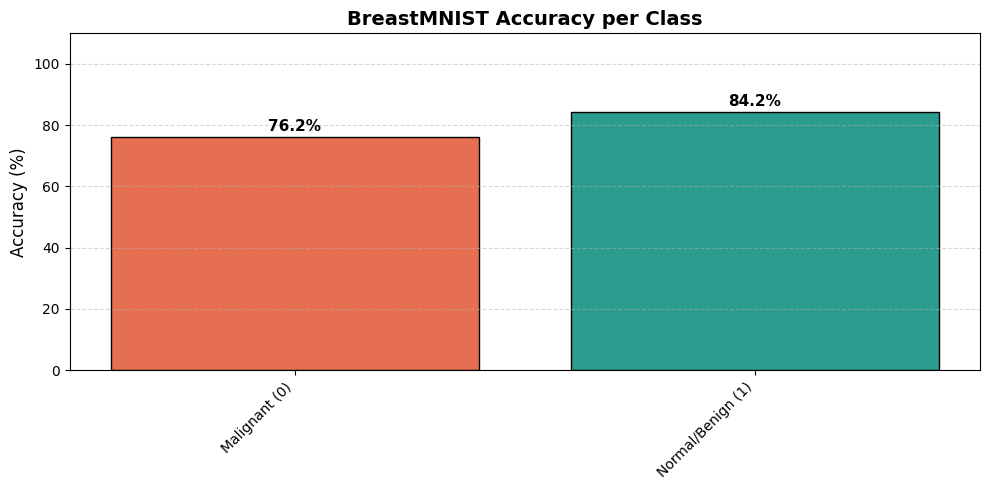


--- Testing PneumoniaMNIST ---


Testing PneumoniaMNIST:   0%|          | 0/20 [00:00<?, ?it/s]

PneumoniaMNIST Overall Accuracy: 85.42%


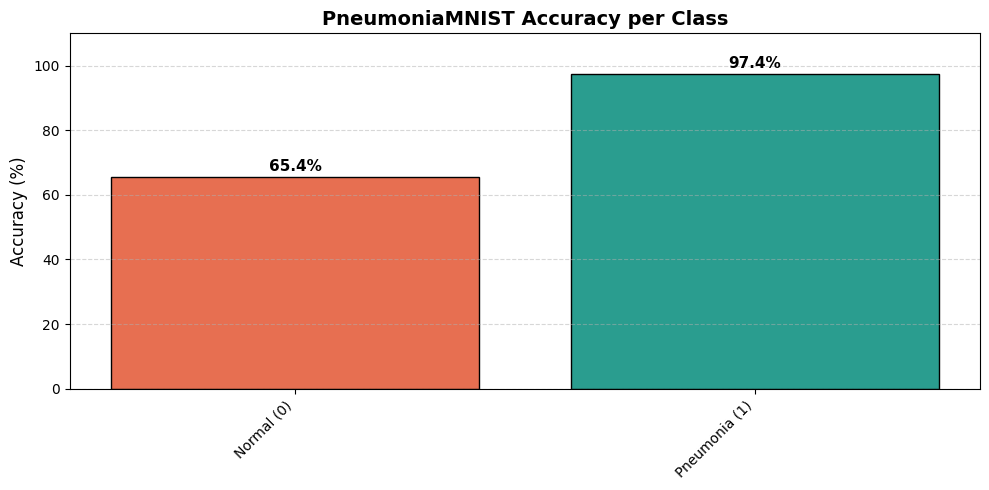


--- Testing ChestMNIST (Multi-Label) ---


Testing ChestMNIST:   0%|          | 0/702 [00:00<?, ?it/s]

ChestMNIST Overall Binary Accuracy: 94.75%


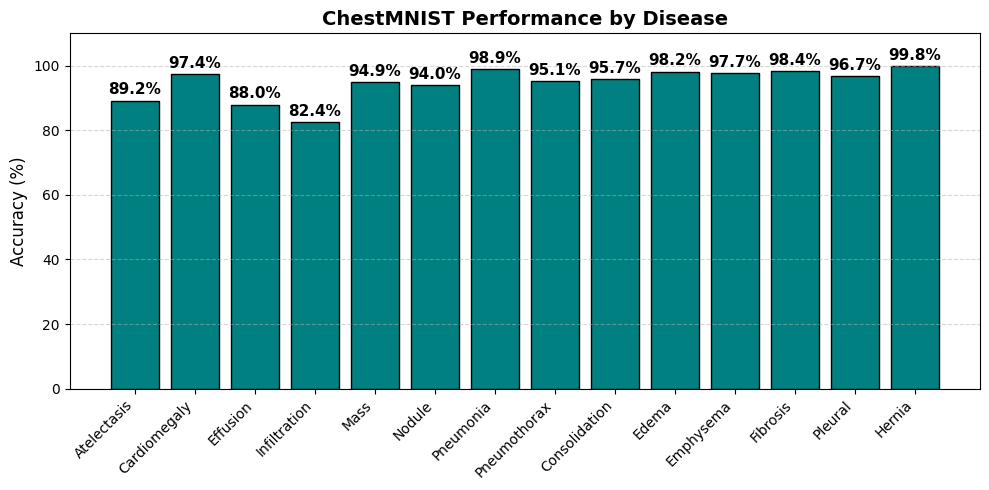


FINAL REPORT
BreastMNIST Accuracy:    82.05%
PneumoniaMNIST Accuracy: 85.42%
ChestMNIST Bin Accuracy: 94.75%


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import medmnist
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


DRIVE_PATH = '/content/drive/MyDrive/amlData'
WEIGHTS_DIR = os.path.join(DRIVE_PATH, 'model_weights')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running Inference on: {device}")

# MODEL DEFINITION
def get_vit_model(num_classes):
    model = models.vit_b_16(weights=None)
    model.heads = nn.Sequential(
        nn.Linear(768, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    return model

# TRANSFORMS
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Plotting func for chest
def plot_bar_chart(accuracies, class_names, title, color='#2a9d8f'):
    plt.figure(figsize=(10, 5))

    # Draw bars
    bars = plt.bar(class_names, accuracies, color=color, edgecolor='black')

    # Styling
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylim(0, 110) # Space at top for numbers
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Add numbers on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()
# --- 5. TEST FUNCTIONS ---

def test_binary_model(dataset_name, weight_file, class_names):
    """Tests Binary Models (Breast/Pneumonia) and plots per-class accuracy"""
    print(f"\n--- Testing {dataset_name} ---")

    # Load Data
    DataClass = getattr(medmnist, dataset_name)
    dataset = DataClass(split='test', transform=data_transform, download=True, root=DRIVE_PATH)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Load Model
    model = get_vit_model(num_classes=2).to(device)
    weight_path = os.path.join(WEIGHTS_DIR, weight_file)
    if not os.path.exists(weight_path):
        print(f"Error: File not found at {weight_path}")
        return 0.0

    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()

    # Tracking per-class accuracy
    correct_counts = [0, 0]
    total_counts = [0, 0]
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Testing {dataset_name}"):
            images, labels = images.to(device), labels.squeeze().long().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # Count specifically for Class 0 vs Class 1
            for lbl, pred in zip(labels, predicted):
                lbl_idx = lbl.item()
                total_counts[lbl_idx] += 1
                if lbl_idx == pred.item():
                    correct_counts[lbl_idx] += 1

    # Calculate Percentages
    overall_acc = 100 * total_correct / total_samples
    class_accs = [
        (correct_counts[0] / total_counts[0] * 100) if total_counts[0] > 0 else 0,
        (correct_counts[1] / total_counts[1] * 100) if total_counts[1] > 0 else 0
    ]

    print(f"{dataset_name} Overall Accuracy: {overall_acc:.2f}%")

    # Plot the Graph immediately
    plot_bar_chart(class_accs, class_names, f"{dataset_name} Accuracy per Class", color=['#e76f51', '#2a9d8f'])

    return overall_acc

def test_multilabel_model(dataset_name, weight_file, class_names):
    """Tests ChestMNIST (14 Classes)"""
    print(f"\n--- Testing {dataset_name} (Multi-Label) ---")

    DataClass = getattr(medmnist, dataset_name)
    dataset = DataClass(split='test', transform=data_transform, download=True, root=DRIVE_PATH)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model = get_vit_model(num_classes=14).to(device)
    weight_path = os.path.join(WEIGHTS_DIR, weight_file)
    if not os.path.exists(weight_path):
        print(f"Error: File not found at {weight_path}")
        return 0.0

    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()

    correct_counts = np.zeros(14)
    total_counts = np.zeros(14)
    total_correct_bits = 0
    total_bits = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Testing {dataset_name}"):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            total_correct_bits += (preds == labels).sum().item()
            total_bits += labels.numel()

            matches = (preds == labels).cpu().numpy()
            correct_counts += matches.sum(axis=0)
            total_counts += matches.shape[0]

    acc = 100 * total_correct_bits / total_bits
    class_accs = (correct_counts / total_counts) * 100

    print(f"{dataset_name} Overall Binary Accuracy: {acc:.2f}%")

    # Plot Chest Graph
    plot_bar_chart(class_accs, class_names, f"{dataset_name} Performance by Disease", color='teal')

    return acc


# Run BreastMNIST
acc_breast = test_binary_model(
    'BreastMNIST',
    'breast_vit_model.pth',
    class_names=['Malignant (0)', 'Normal/Benign (1)']
)

# Run PneumoniaMNIST
acc_pneu = test_binary_model(
    'PneumoniaMNIST',
    'pneumonia_vit_model.pth',
    class_names=['Normal (0)', 'Pneumonia (1)']
)

# Run ChestMNIST
chest_classes = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass",
    "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", "Edema",
    "Emphysema", "Fibrosis", "Pleural", "Hernia"
]
acc_chest = test_multilabel_model(
    'ChestMNIST',
    'chest_vit_model.pth',
    chest_classes
)

# Final Text Summary
print("\n" + "="*40)
print("FINAL REPORT")
print("="*40)
print(f"BreastMNIST Accuracy:    {acc_breast:.2f}%")
print(f"PneumoniaMNIST Accuracy: {acc_pneu:.2f}%")
print(f"ChestMNIST Bin Accuracy: {acc_chest:.2f}%")
print("="*40)